In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
warnings.simplefilter('ignore')

In [3]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")


In [4]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.isnull().sum().sum()

0

In [6]:
train_X = train_df.drop("label",axis=1)
train_Y = train_df["label"]

In [7]:
train_X = train_X/255
test = test/255

In [8]:
train_X = train_X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [10]:
train_Y = to_categorical(train_Y, num_classes = 10)

In [30]:
X_train, X_val, Y_train, Y_val = train_test_split(train_X, train_Y, test_size = 0.2, random_state=2)

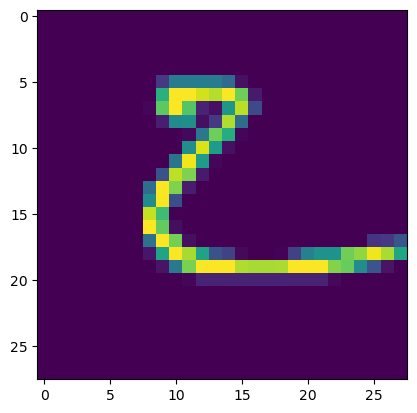

In [31]:
g = plt.imshow(X_train[0][:,:,0])

KerasのSequential APIを使い、入力から順番に1層ずつ追加していけばいいだけです。

最初は畳み込み（Conv2D）層です。これは学習可能なフィルタのセットのようなものです。最初の2つのConv2D層には32のフィルターを、最後の2つの層には64のフィルターを設定することにしました。各フィルタは、カーネルフィルタを用いて画像の一部（カーネルサイズによって定義される）を変換する。カーネルフィルター行列は画像全体に適用されます。フィルタは画像の変換と見なすことができる。

CNNは、この変換された画像（特徴マップ）から、どこでも役に立つ特徴を分離することができる。

CNNの2番目の重要な層は、プーリング（MaxPool2D）層である。この層は単にダウンサンプリングフィルタとして機能する。隣接する2つのピクセルを見て、最大値を選びます。これらは計算コストを削減するために使用され、ある程度オーバーフィッティングを減らすこともできる。プーリングサイズ（すなわち、毎回プールされる領域サイズ）を選択する必要があり、プーリング次元が高ければ高いほど、ダウンサンプリングが重要になる。

畳み込み層とプーリング層を組み合わせることで、CNNは局所的な特徴を組み合わせ、よりグローバルな画像の特徴を学習することができる。

ドロップアウトは正則化手法の一つで、各トレーニングサンプルに対して、層内のノードの一部をランダムに無視する（ウェイトをゼロにする）。これにより、ネットワークの一部をランダムに削除し、ネットワークに分散して特徴を学習させることができます。また、この手法により汎化性が向上し、オーバーフィッティングが減少します。

relu」は整流器（活性化関数max(0,x)）です。整流器活性化関数は、ネットワークに非直線性を持たせるために使用されます。

Flatten層は、最終的な特徴マップを1つの単一1次元ベクトルに変換するために使用されます。この平坦化ステップは、畳み込み/マックスプール層の後に完全接続層を利用できるようにするために必要である。これは、前の畳み込み層で見つかったすべての局所的な特徴を結合するものです。

最終的に、私は2つの完全接続層（Dense）で特徴を使いました。これは単なる人工ニューラルネットワーク（ANN）分類器です。最後の層（Dense(10,activation="softmax")）では、各クラスの確率の分布を出力します。

https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6?scriptVersionId=1437220&cellId=28

In [32]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [33]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [34]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [36]:
epochs = 1
batch_size = 86

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [38]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

390/390 - 103s - loss: 0.4822 - accuracy: 0.8432 - val_loss: 0.0771 - val_accuracy: 0.9780 - lr: 0.0010 - 103s/epoch - 264ms/step


263/263 [==============================] - 6s 21ms/step


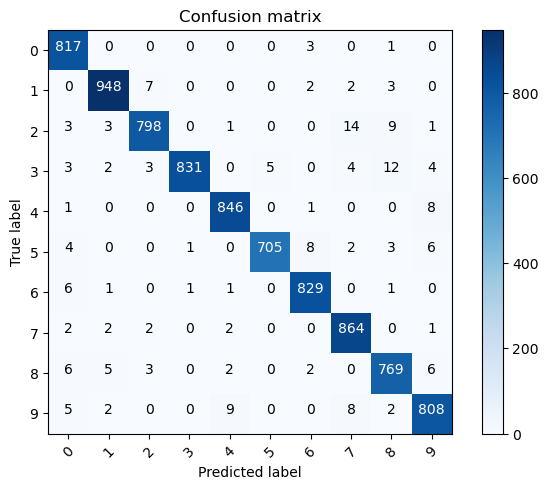

In [39]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [40]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 18s 21ms/step


In [41]:
sub = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
sub["Label"] = results
sub.to_csv("/kaggle/working/cnn.csv",index=False)